In [7]:
import os
import numpy as np
from PIL import Image
import cv2 as cv
import open3d as o3d
import matplotlib.pyplot as plt

In [8]:
import numpy as np

with np.load('aryan_calibration_data.npz') as calibration_data:
    callibration1 = calibration_data['mtx']
    distortion1 = calibration_data['dist'][0]

In [9]:
print(callibration1)
print(distortion1)

[[3.04178524e+03 0.00000000e+00 1.58771586e+03]
 [0.00000000e+00 3.03739654e+03 1.51810990e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 3.94833030e-02 -4.67790713e-01  1.20152321e-03  5.50505183e-04
  1.81732987e+00]


In [10]:
import numpy as np

with np.load('shreyansh_calibration_data.npz') as calibration_data1:
    callibration2 = calibration_data1['mtx']
    distortion2 = calibration_data1['dist'][0]

In [11]:
print(callibration2)
print(distortion2)

[[3.56540666e+03 0.00000000e+00 8.91159296e+02]
 [0.00000000e+00 3.54756591e+03 1.72571554e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[-3.58849190e-01  2.96254433e+00 -1.40636522e-02 -1.73995515e-03
 -9.49290094e+00]


In [12]:
import re
def natural_sort_key(key):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', key)]

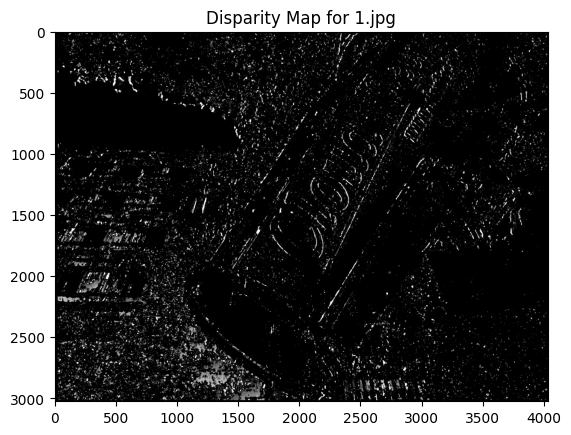

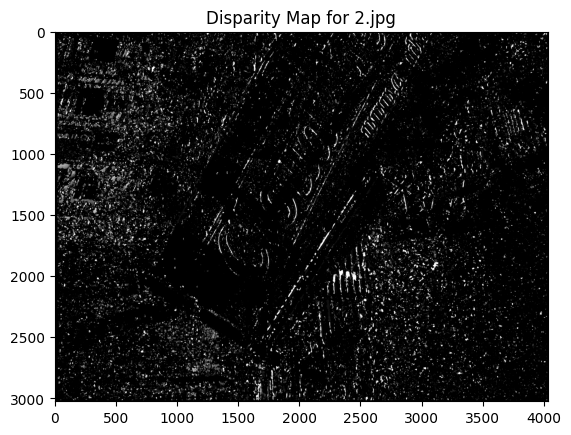

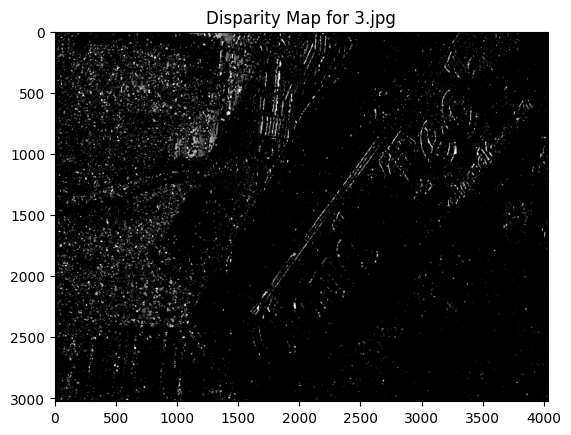

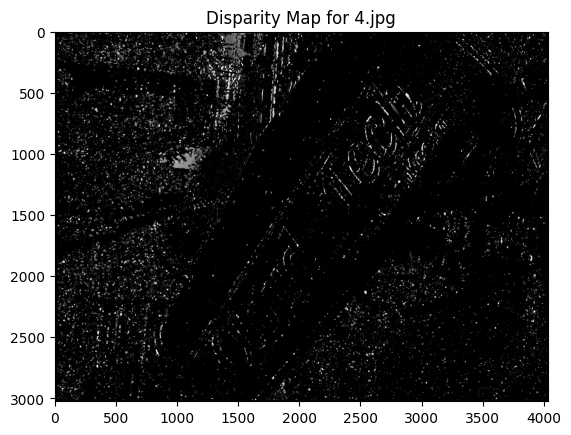

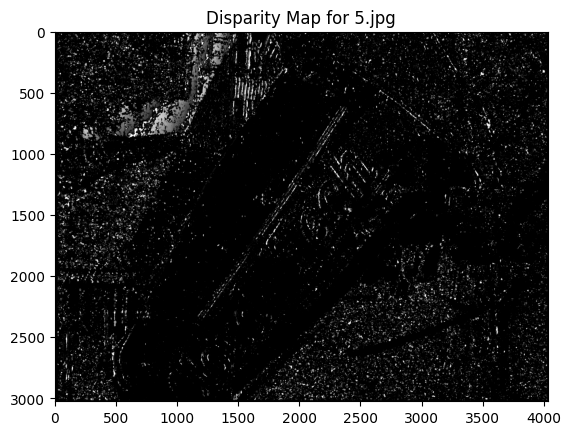

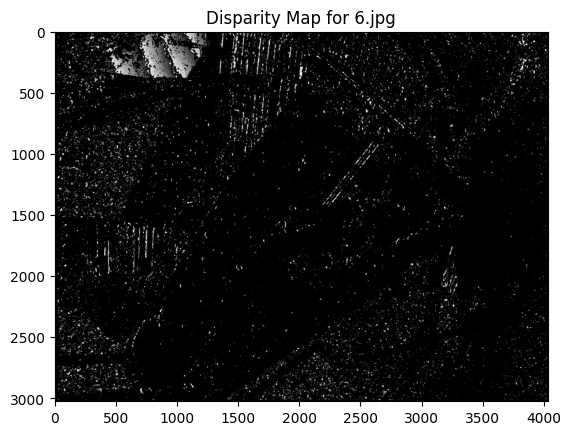

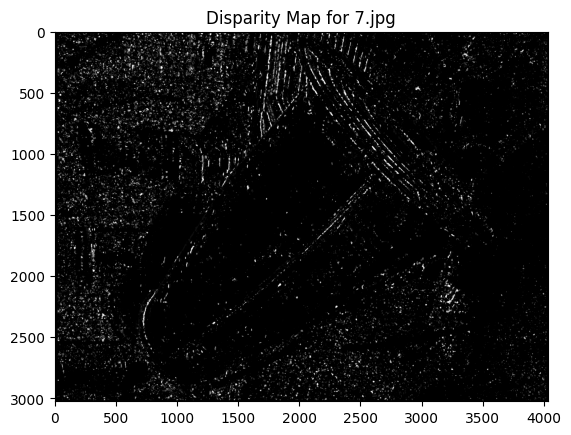

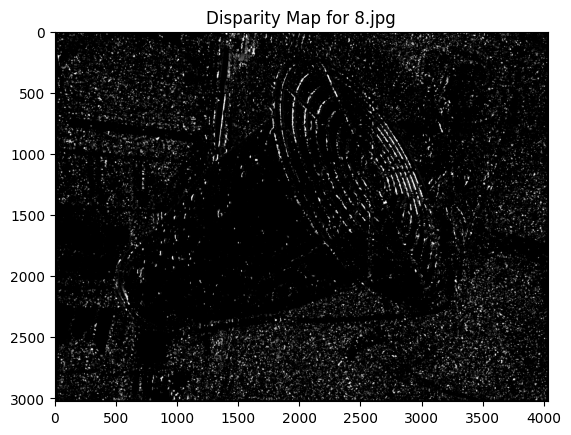

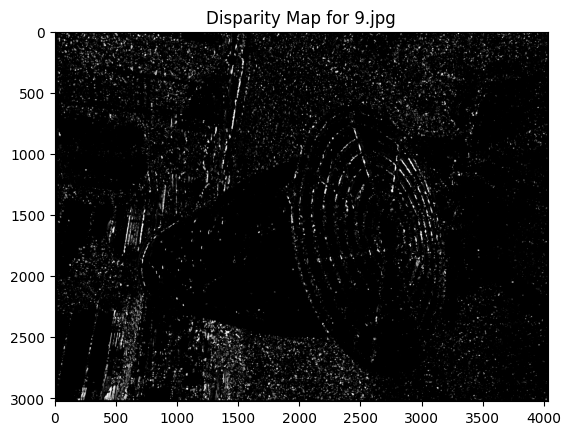

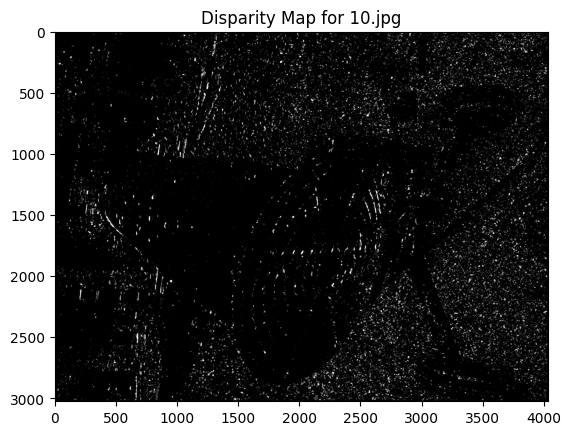

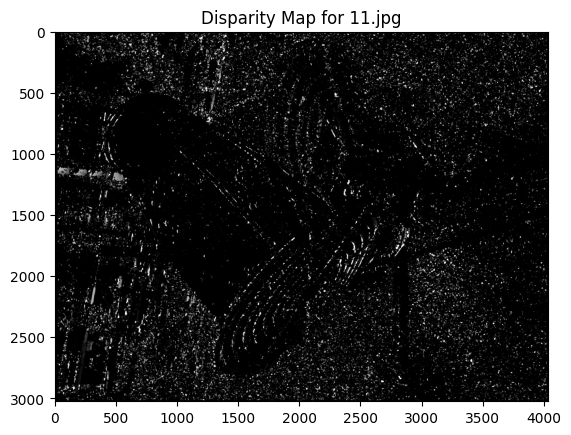

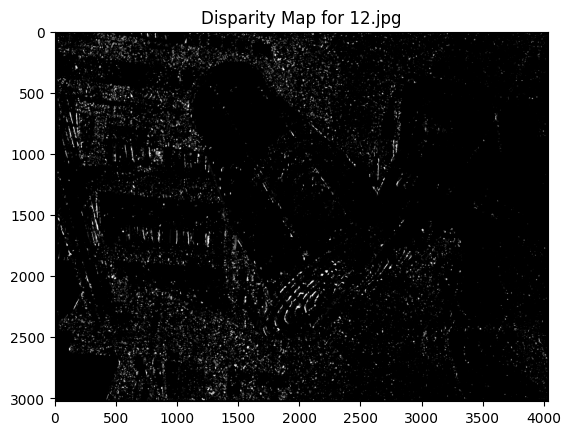

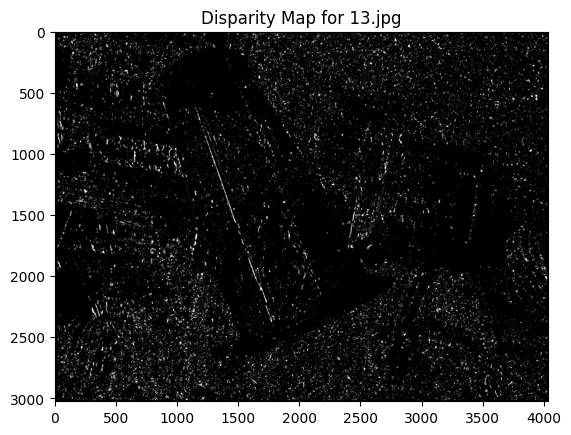

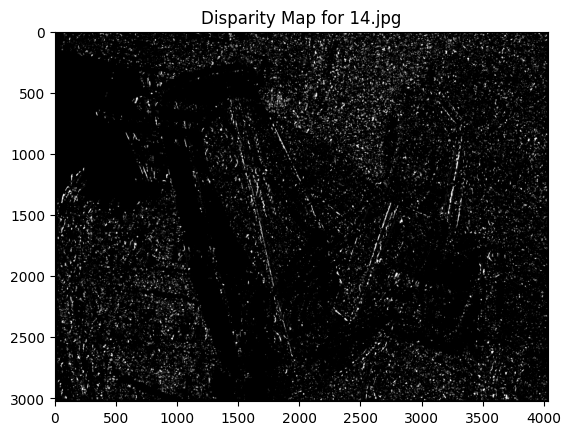

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2 as cv
import open3d as o3d
import matplotlib.pyplot as plt

folder_left = 'datasets/Aryan_water_dispenser'
folder_right = 'datasets/shreyansh_water_dispenser'

# Initialize an empty list for point clouds
point_clouds = []

# Loop through images in both folders
for filename in sorted(os.listdir(folder_left), key=natural_sort_key):
    if filename in os.listdir(folder_right):  # Ensure the file exists in both folders
        # Load images
        img_left = Image.open(os.path.join(folder_left, filename))
        img_right = Image.open(os.path.join(folder_right, filename))
        
        # Resize images to the same size
        new_size = (min(img_left.size[0], img_right.size[0]), min(img_left.size[1], img_right.size[1]))
        img_left = img_left.resize(new_size)
        img_right = img_right.resize(new_size)

        # Convert to OpenCV format
        img_left = cv.cvtColor(np.array(img_left), cv.COLOR_RGB2BGR)
        img_right = cv.cvtColor(np.array(img_right), cv.COLOR_RGB2BGR)

        # Convert to grayscale
        img_left_gray = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
        img_right_gray = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)

        # Compute the Q matrix
        Q = np.zeros((4, 4))
        R = np.identity(3)  # Rotation matrix
        cv.stereoRectify(cameraMatrix1=callibration1, cameraMatrix2=callibration2,
                         distCoeffs1=distortion1, distCoeffs2=distortion2,
                         imageSize=img_left_gray.shape[::-1], R=R, T=np.array([0.54, 0., 0.]),
                         R1=None, R2=None, P1=None, P2=None, Q=Q)

        # Compute disparity
        stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
        disparity = stereo.compute(img_left_gray, img_right_gray)

        # Normalize disparity for visualization
        disparity_norm = cv.normalize(disparity, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        plt.imshow(disparity_norm, cmap='gray')
        plt.title(f"Disparity Map for {filename}")
        plt.show()

        # Reproject to 3D space
        points_3D = cv.reprojectImageTo3D(disparity, Q)
        mask = disparity > disparity.min()
        points_3D = points_3D[mask]
        colors = cv.cvtColor(img_left, cv.COLOR_BGR2RGB)[mask]

        # Convert to Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points_3D)
        pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)

        # Add to the list of point clouds
        point_clouds.append(pcd)

# Stitch point clouds using ICP
if point_clouds:
    merged_cloud = point_clouds[0]
    for i in range(1, len(point_clouds)):
        # Registration
        threshold = 0.02
        trans_init = np.eye(4)
        reg_p2p = o3d.pipelines.registration.registration_icp(
            merged_cloud, point_clouds[i], threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )
        point_clouds[i].transform(reg_p2p.transformation)
        merged_cloud += point_clouds[i]

    # Visualize the stitched point cloud
    o3d.visualization.draw_geometries([merged_cloud])

    # Save the stitched point cloud
    o3d.io.write_point_cloud("stitched_output.ply", merged_cloud)